In [ ]:
# bismillahirrahmanirrahim

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install -q transformers datasets

     |████████████████████████████████| 5.5 MB 7.7 MB/s 
     |████████████████████████████████| 451 kB 62.4 MB/s 
     |████████████████████████████████| 182 kB 68.1 MB/s 
     |████████████████████████████████| 7.6 MB 53.4 MB/s 
     |████████████████████████████████| 115 kB 72.0 MB/s 
     |████████████████████████████████| 212 kB 73.7 MB/s 
     |████████████████████████████████| 127 kB 61.9 MB/s 


In [ ]:
import pandas as pd
import numpy as np
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import ViTFeatureExtractor, ViTForImageClassification
from transformers import AutoFeatureExtractor, ResNetForImageClassification
from transformers import Trainer, TrainingArguments
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from datasets import Dataset, DatasetDict
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from datasets import ClassLabel, Value
from tqdm.auto import tqdm

In [ ]:
df = pd.read_csv('./drive/MyDrive/ITMO Master/datasets/ml-industry/task2_1/compiled.csv', index_col=0)
# make multilabel
onehot_labels = pd.get_dummies(df.genre)
df.loc[:, onehot_labels.columns] = onehot_labels
# distribute labels
for c in onehot_labels.columns:
    df[c] = df['labels'].apply(lambda labels: 1 if c in labels else 0)

In [ ]:
zero_label = df.loc[:, 'Action':].sum(axis=1)
zero_label = zero_label[zero_label <= 0]
zero_label.index

Int64Index([2677, 2681, 2684, 2686, 2687, 2688, 2753, 2775, 2823, 2866, 2868,
            2883, 2904, 2910, 2932, 4813, 4817, 4836, 4837, 4843, 4905, 4926,
            4927, 4933, 4939, 4940, 4966, 4980, 4986, 4994, 5003, 5022, 5040,
            5042, 5058, 5336, 5360, 5393, 5397, 5424, 5434, 5435, 5446, 5466,
            5478, 5483, 5495, 5504, 5508, 5511, 5515, 5518, 5525, 5530, 5532,
            5538, 5546, 5550, 5556, 5565, 5566, 5581],
           dtype='int64')

In [ ]:
# assign onehot label from its genre instead
for index in zero_label.index:
    # get genre
    genre = df[df.index == index]['genre']
    # assign label
    df.loc[df.index == index, genre] = 1

In [ ]:
# final check
ssum = df.loc[:, 'Action':].sum(axis=1)
print(ssum[ssum <= 0])

# and export data :)
df.to_csv('/content/drive/MyDrive/ITMO Master/datasets/ml-industry/task2_1/processed-multilabel.csv', header=True, index=False)

Series([], dtype: int64)


In [ ]:
df = pd.read_csv('./drive/MyDrive/ITMO Master/datasets/ml-industry/task2_1/processed-multilabel.csv')
# df['img_local_path'] = df['img_local_path'].apply(lambda x: x.replace('./', './drive/MyDrive/ITMO Master/'))
df.head(2)

,title,simple_desc,genre,img_local_path,labels,Action,Adventure,Animation,Biography,Comedy,...,Musical,Mystery,Romance,Sci-Fi,Short Film,Sport,Superhero,Thriller,War,Western
0,Andor,Prequel series to Star Wars' 'Rogue One'. In a...,Action,/content/drive/MyDrive/ITMO Master/datasets/ml...,"Action, Adventure, Drama",1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,House of the Dragon,An internal succession war within House Targar...,Action,/content/drive/MyDrive/ITMO Master/datasets/ml...,"Action, Adventure, Drama",1,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
labels = list(df.columns)[5:]
label2id = {v: k for k, v in enumerate(labels)}
id2label = {k: v for k, v in enumerate(labels)}

len(labels)

24

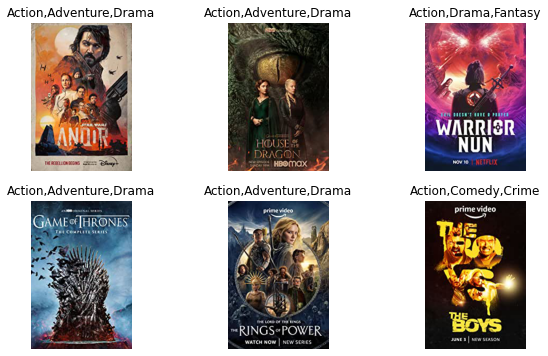

In [ ]:
datasets = Dataset.from_pandas(df)
samples = datasets.select(range(6))
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        _labels = ','.join([k for k, v in list(samples[pointer].items())[5:] if v == 1])
        ax[i,j].imshow(Image.open(samples[pointer]['img_local_path']))
        ax[i,j].set_title(_labels)
        ax[i,j].axis('off')
        pointer+=1

plt.show()

In [ ]:
def get_label(example):
    example['labels'] = list(example.values())[5:]
    return example

In [ ]:
new_features = datasets.features.copy()
new_features['genre'] = ClassLabel(names=labels)
datasets = datasets.cast(new_features)

Casting the dataset:   0%|          | 0/7 [00:00<?, ?ba/s]

In [ ]:
# preprocess
dataset = datasets.map(get_label, remove_columns=datasets.column_names[5:])
dataset = dataset.train_test_split(0.2, seed=42, stratify_by_column='genre')
# make validation split
# split_dataset = dataset['train'].train_test_split(0.25, seed=42, stratify_by_column='genre')
# dataset['train'] = split_dataset['train']
# dataset['validation'] = split_dataset['test']

dataset

  0%|          | 0/6399 [00:00<?, ?ex/s]

DatasetDict({
    train: Dataset({
        features: ['title', 'simple_desc', 'genre', 'img_local_path', 'labels'],
        num_rows: 5119
    })
    test: Dataset({
        features: ['title', 'simple_desc', 'genre', 'img_local_path', 'labels'],
        num_rows: 1280
    })
})

In [ ]:
model_ckpt = 'google/vit-base-patch16-224-in21k'
# resnet_ckpt = 'microsoft/resnet-50'
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
extractor = ViTFeatureExtractor.from_pretrained(model_ckpt)
# extractor = AutoFeatureExtractor.from_pretrained(resnet_ckpt)

In [ ]:
def batch_transform(samples):    
    # take a list of PIL images and turn into pixel values
    inputs = extractor([Image.open(x).convert('RGB') for x in samples['img_local_path']], return_tensors='pt')
    # add the labels
    inputs['labels'] = torch.Tensor(samples['labels'])

    return inputs

In [ ]:
transformed_data = dataset.with_transform(batch_transform)
transformed_data

DatasetDict({
    train: Dataset({
        features: ['title', 'simple_desc', 'genre', 'img_local_path', 'labels'],
        num_rows: 5119
    })
    test: Dataset({
        features: ['title', 'simple_desc', 'genre', 'img_local_path', 'labels'],
        num_rows: 1280
    })
})

In [ ]:
transformed_data['train'][0]['labels']

tensor([0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0.])

In [ ]:
def collate_fn(examples):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in examples]),
        'labels': torch.stack([x['labels'] for x in examples])
    }

def multilabel_metrics(predictions, labels, threshold=0.5):
    # apply sigmoid on predictions
    sigmoid = torch.nn.Sigmoid()
    probs = sigmoid(torch.Tensor(predictions))
    # use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # compute metrics
    y_true = labels
    f1_micro_avg = f1_score(y_true, y_pred, average='micro')
    roc_auc = roc_auc_score(y_true, y_pred, average='micro')
    accuracy = accuracy_score(y_true, y_pred)

    metrics = {'f1': f1_micro_avg,
                'roc_auc': roc_auc,
                'accuracy': accuracy}

    return metrics

def compute_metrics(p):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    result = multilabel_metrics(predictions=preds, labels=p.label_ids)
    return result

### Finetuning ViT Image model

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
model = ViTForImageClassification.from_pretrained(model_ckpt, num_labels=len(labels),
                                                  id2label=id2label, label2id=label2id,
                                                  problem_type='multi_label_classification',
                                                  ignore_mismatched_sizes=True)

model = model.to(device)

Downloading:   0%|          | 0.00/502 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of the model checkpoint at google/vit-base-patch16-224-in21k were not used when initializing ViTForImageClassification: ['pooler.dense.bias', 'pooler.dense.weight']
- This IS expected if you are initializing ViTForImageClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ViTForImageClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
batch_size = 64
logging_steps = len(transformed_data['train']) // batch_size

In [ ]:
training_args = TrainingArguments(output_dir='/content/',
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  evaluation_strategy='epoch',
                                  save_strategy='epoch',
                                  num_train_epochs=5,
                                  fp16=True if torch.cuda.is_available() else False,
                                  logging_steps=logging_steps,
                                  learning_rate=5e-5,
                                  save_total_limit=2,
                                  remove_unused_columns=False,
                                  load_best_model_at_end=True)

In [ ]:
trainer = Trainer(model=model,
                  args=training_args,
                  data_collator=collate_fn,
                  compute_metrics=compute_metrics,
                  train_dataset=transformed_data['train'],
                  eval_dataset=transformed_data['test'],
                  tokenizer=extractor)

train_result = trainer.train()

Using cuda_amp half precision backend
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 5119
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 400
  Number of trainable parameters = 85817112


Epoch,Training Loss,Validation Loss,F1,Roc Auc,Accuracy
1,0.467500,0.389311,0.264884,0.577782,0.024219
2,0.359700,0.334356,0.298028,0.590410,0.027344
3,0.320700,0.308972,0.307468,0.593951,0.027344
4,0.301500,0.297460,0.309605,0.594525,0.027344
5,0.292400,0.294014,0.310404,0.594659,0.027344


***** Running Evaluation *****
  Num examples = 1280
  Batch size = 64
Saving model checkpoint to /content/checkpoint-80
Configuration saved in /content/checkpoint-80/config.json
Model weights saved in /content/checkpoint-80/pytorch_model.bin
Feature extractor saved in /content/checkpoint-80/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1280
  Batch size = 64
Saving model checkpoint to /content/checkpoint-160
Configuration saved in /content/checkpoint-160/config.json
Model weights saved in /content/checkpoint-160/pytorch_model.bin
Feature extractor saved in /content/checkpoint-160/preprocessor_config.json
***** Running Evaluation *****
  Num examples = 1280
  Batch size = 64
Saving model checkpoint to /content/checkpoint-240
Configuration saved in /content/checkpoint-240/config.json
Model weights saved in /content/checkpoint-240/pytorch_model.bin
Feature extractor saved in /content/checkpoint-240/preprocessor_config.json
Deleting older checkpoint [/content/ch

In [ ]:
trainer.evaluate()

***** Running Evaluation *****
  Num examples = 1280
  Batch size = 64


{'eval_loss': 0.2940138876438141,
 'eval_f1': 0.3104039167686658,
 'eval_roc_auc': 0.5946591223334781,
 'eval_accuracy': 0.02734375,
 'eval_runtime': 13.3475,
 'eval_samples_per_second': 95.898,
 'eval_steps_per_second': 1.498,
 'epoch': 5.0}

In [ ]:
# trainer.predict(transformed_data['test']).metrics

***** Running Prediction *****
  Num examples = 960
  Batch size = 64


In [ ]:
sample = dataset['test'].select(range(6))
extracted_feature = extractor([Image.open(x).convert('RGB') for x in sample['img_local_path']], return_tensors='pt').to(device)
out = trainer.model(**extracted_feature)

In [ ]:
sample

Dataset({
    features: ['title', 'simple_desc', 'genre', 'img_local_path', 'labels'],
    num_rows: 6
})

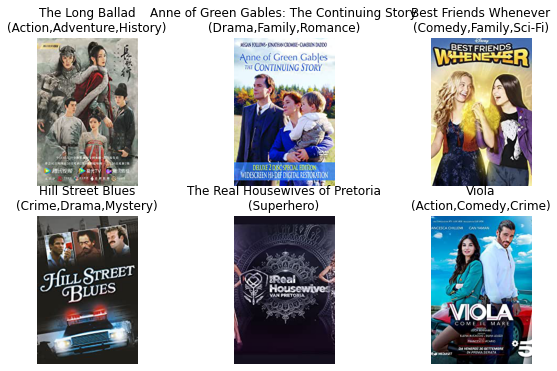

In [ ]:
pointer = 0

fig, ax = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(10,6))
for i in range(2):
    for j in range(3):
        _labels = ','.join([id2label[i] for i, x in enumerate(sample['labels'][pointer]) if x == 1])
        ax[i,j].imshow(Image.open(sample[pointer]['img_local_path']))
        ax[i,j].set_title(f"{sample['title'][pointer]}\n({_labels})")
        ax[i,j].axis('off')
        pointer+=1

plt.show()

In [ ]:
sigmoid = torch.nn.Sigmoid()
sigmoid_out = sigmoid(out.logits.detach().cpu())
label_out = torch.topk(sigmoid_out, 3)[1].numpy()
for line in label_out:
    print([id2label[x] for x in line])

['Drama', 'Comedy', 'Crime']
['Drama', 'Comedy', 'Crime']
['Drama', 'Comedy', 'Action']
['Drama', 'Crime', 'Comedy']
['Drama', 'Comedy', 'Crime']
['Drama', 'Comedy', 'Crime']


In [ ]:
for line in label_out:
    print(sorted([id2label[x] for x in line]))

['Comedy', 'Crime', 'Drama']
['Comedy', 'Crime', 'Drama']
['Action', 'Comedy', 'Drama']
['Comedy', 'Crime', 'Drama']
['Comedy', 'Crime', 'Drama']
['Comedy', 'Crime', 'Drama']


### Save Model

In [ ]:
trainer.save_model('/content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/vit-pretrained')

Saving model checkpoint to /content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/vit-pretrained
Configuration saved in /content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/vit-pretrained/config.json
Model weights saved in /content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/vit-pretrained/pytorch_model.bin
Feature extractor saved in /content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/vit-pretrained/preprocessor_config.json


In [ ]:
del model
torch.cuda.empty_cache()

### Getting logits for each set

In [ ]:
model = ViTForImageClassification.from_pretrained('/content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/vit-pretrained')
model = model.to(device)

loading configuration file /content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/vit-pretrained/config.json
Model config ViTConfig {
  "_name_or_path": "google/vit-base-patch16-224-in21k",
  "architectures": [
    "ViTForImageClassification"
  ],
  "attention_probs_dropout_prob": 0.0,
  "encoder_stride": 16,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.0,
  "hidden_size": 768,
  "id2label": {
    "0": "Action",
    "1": "Adventure",
    "2": "Animation",
    "3": "Biography",
    "4": "Comedy",
    "5": "Crime",
    "6": "Documentary",
    "7": "Drama",
    "8": "Family",
    "9": "Fantasy",
    "10": "Film Noir",
    "11": "History",
    "12": "Horror",
    "13": "Music",
    "14": "Musical",
    "15": "Mystery",
    "16": "Romance",
    "17": "Sci-Fi",
    "18": "Short Film",
    "19": "Sport",
    "20": "Superhero",
    "21": "Thriller",
    "22": "War",
    "23": "Western"
  },
  "image_size": 224,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id

In [ ]:
# create loader
trainloader = DataLoader(transformed_data['train'], batch_size=batch_size)
# validloader = DataLoader(transformed_data['validation'], batch_size=batch_size)
testloader = DataLoader(transformed_data['test'], batch_size=batch_size)

In [ ]:
# collect all train logits
all_logits = []

for batch in tqdm(trainloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    out = model(**batch).logits.detach().cpu()
    all_logits.append(out)

  0%|          | 0/80 [00:00<?, ?it/s]

In [ ]:
import pickle

with open('/content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/vit-logits/train-logits.pkl', 'wb') as f:
    logits = torch.cat(all_logits)
    pickle.dump(logits, f)

torch.cuda.empty_cache()

In [ ]:
# # collect validation logits
# val_logits = []

# for batch in tqdm(validloader):
#     batch = {k: v.to(device) for k, v in batch.items()}
#     out = model(**batch).logits.detach().cpu()
#     val_logits.append(out)

# torch.cuda.empty_cache()

  0%|          | 0/22 [00:00<?, ?it/s]

In [ ]:
# import pickle

# with open('/content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/vit-logits/val-logits.pkl', 'wb') as f:
#     logits = torch.cat(val_logits)
#     pickle.dump(logits, f)

In [ ]:
# collect test logits
test_logits = []

for batch in tqdm(testloader):
    batch = {k: v.to(device) for k, v in batch.items()}
    out = model(**batch).logits.detach().cpu()
    test_logits.append(out)

torch.cuda.empty_cache()

  0%|          | 0/20 [00:00<?, ?it/s]

In [ ]:
import pickle

with open('/content/drive/MyDrive/ITMO Master/datasets/ml-industry/models/vit-logits/test-logits.pkl', 'wb') as f:
    logits = torch.cat(test_logits)
    pickle.dump(logits, f)

In [ ]:
logits.shape

torch.Size([1280, 24])